In [24]:

def measure_area(region):
    ''' Measures area of a specified region
    Args:
    Region: A region from the drawing
    '''
    return f"100"


def get_scale(drawing):
    ''' Fetches the scale used in a drawing
    Args:
    drawing: A drawing object
    '''
    # drawing processing steps
    scale = 'meter'
    return scale


def query_pipe_info(location):
    '''
    Returns information about a water pipe at a specified location.

    Args:
    location: A location in the drawing

    Returns:
    A dictionary containing attributes about the pipe, such as:
      - pipe_id
      - diameter
      - length
      - installation_date
      - last_inspection_date
      - condition
    '''
    pipe_information = {
        "pipe_id": "WP-1023",
        "diameter": "300 mm",
        "length": "45.7 meters",
        "installation_date": "2015-06-23",
        "last_inspection_date": "2024-12-15",
        "condition": "Good"
    }

    return pipe_information 



async def system_prompt():
    return """
    You are a helpful construction assistant that can answer questions and help with tasks.
    You have access to the following tools:
    - measure_area
    - get_scale
    - query_pipe_info

    You can use these tools to answer questions and help with tasks.
    Note: 
    * If the user query is unrelated, mention that you are a construction assistant and you can only help with construction related tasks, then mention the tasks you can perform(using your tools list).
    * If the user query is ambiguous, ask for more details using the tool arguments you need to help the user.
    """ 

In [35]:
import os
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
import asyncio
from langchain_mcp_adapters.client import MultiServerMCPClient
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.checkpoint.memory import MemorySaver
from pathlib import Path

from state import MessagesState

load_dotenv()

GOOGLE_API_KEY = os.environ.get('GOOGLE_API_KEY')

# Get the project root directory
PROJECT_ROOT = Path(os.getcwd()).parent.parent.parent
tools = [measure_area, get_scale, query_pipe_info]
def create_graph():
    llm = ChatGoogleGenerativeAI(model = 'gemini-2.0-flash', temperature=0, google_api_key = GOOGLE_API_KEY)

    llm_with_tools = llm.bind_tools(tools)
    
    sys_prompt = SystemMessage(content = str(system_prompt))
    
    def intent_and_slot_validator(state: MessagesState):
        user_query = input('Enter your query: ')
        return {'messages': [HumanMessage(content=user_query)]}
    
    def agent_call(state: MessagesState):
        # summary will help reducing token count
        return {'messages': llm_with_tools.invoke([sys_prompt] + [state['summary']] + state['messages'])}

    builder = StateGraph(MessagesState)

    builder.add_node('Query Validator', intent_and_slot_validator)
    builder.add_node('Agent', agent_call)
    builder.add_node('tools', ToolNode(tools))
    # LOGIC
    builder.add_edge(START, 'Query Validator')
    builder.add_edge('Query Validator', 'Agent')
    builder.add_conditional_edges('Agent', tools_condition)
    builder.add_edge('tools', 'Query Validator')

    memory = MemorySaver()
    graph = builder.compile(checkpointer=memory)

    return graph



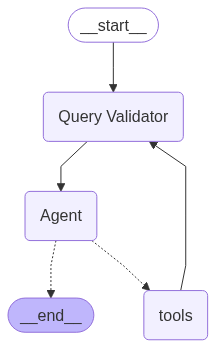

In [37]:
graph = create_graph()
graph